*Think Linear Algebra* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# To Boldly Go



[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkLinearAlgebra/blob/main/nb/track.ipynb).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkLinearAlgebra/raw/main/utils.py")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import decorate, underride

## Section



https://airandspace.si.edu/collection-media/NASM-A19740668000-NASM2016-02354-000005
https://airandspace.si.edu/collection-media/NASM-A19740668000-NASM2016-02687-000001

In [4]:
filename = "NASM-A19740668000-NASM2016-02687-000001.jpg"

In [5]:
import matplotlib.pyplot as plt
from skimage import io, color, filters, measure, morphology
import numpy as np

image = io.imread(filename)
gray = color.rgb2gray(image)

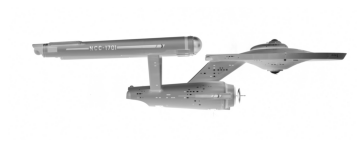

In [6]:
plt.imshow(gray, cmap="gray_r")
plt.axis("off")
None

In [7]:
smoothed = filters.gaussian(gray, sigma=5.0)  # Higher sigma = more blur

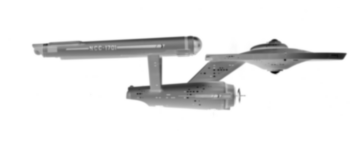

In [8]:
plt.imshow(smoothed, cmap="gray_r")
plt.axis("off")
None

In [9]:
binary = smoothed > 0.05

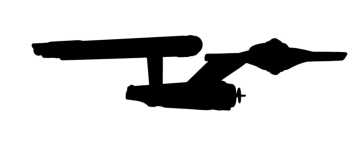

In [10]:
plt.imshow(binary, cmap="gray_r")
plt.axis("off")
None

In [11]:
contours = measure.find_contours(binary, level=0.5)
contour = contours[0]
contour.shape

(9647, 2)

Each point is identified by a row and column, in that order.

In [12]:
ys, xs = np.transpose(contour)

In [13]:
from shapely.geometry import LineString

line = LineString(np.transpose([xs, ys]))
simplified = line.simplify(tolerance=10.0, preserve_topology=True)

coords = np.array(simplified.coords)
coords.shape

(55, 2)

In [14]:
def plot_contour(W, **options):
    underride(options, color="C0", alpha=0.5)
    xs, ys = W.T
    plt.plot(xs, ys, **options)
    decorate(aspect='equal')

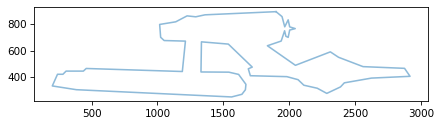

In [15]:
plot_contour(coords)

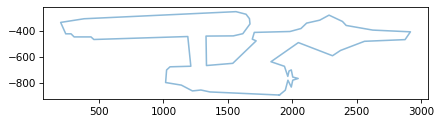

In [16]:
flipped = coords * [1, -1]
plot_contour(flipped)

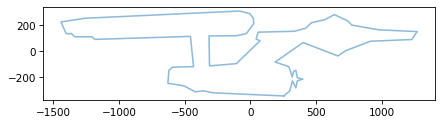

In [17]:
mean = flipped.mean(axis=0)
shifted = flipped - mean

plot_contour(shifted)
decorate(aspect='equal')

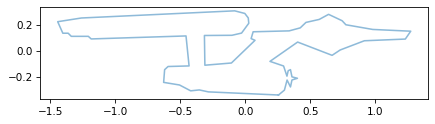

In [18]:
scaled = shifted / 1000
plot_contour(scaled)

In [19]:
ship = scaled

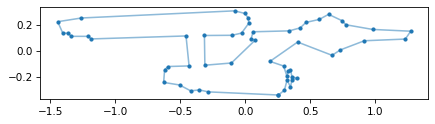

In [20]:
plot_contour(ship)
xs, ys = ship.T
lines = plt.plot(xs, ys, ".")

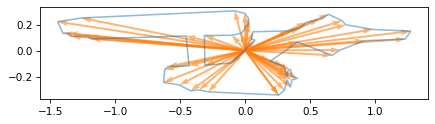

In [21]:
from utils import plot_vectors

plot_contour(ship)
plot_vectors(ship, width=0.005, color="C1")


In [22]:
rolled = np.roll(ship, shift=1, axis=0)
diffs = rolled - ship

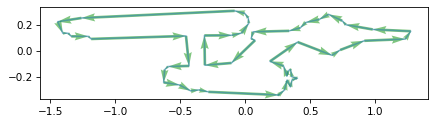

In [23]:
plot_contour(ship)
plot_vectors(diffs, ship, width=0.007, color="C2")

In [24]:
def scale_matrix(sx, sy):
    return np.array([[sx, 0], [0, sy]])

In [25]:
from sympy import symbols, Matrix

def make_vector(x, y):
    return Matrix([[x, y]])

In [26]:
x, y, sx, sy = symbols('x y s_x s_y')

v = make_vector(x, y)
S = scale_matrix(sx, sy)
Matrix(S)

Matrix([
[s_x,   0],
[  0, s_y]])

In [27]:
v @ S

Matrix([[s_x*x, s_y*y]])

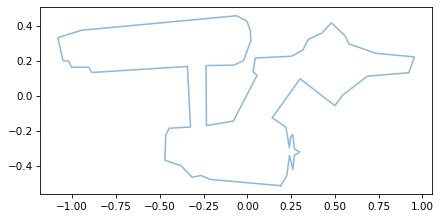

In [28]:
S = scale_matrix(0.75, 1.5)
scaled = ship @ S

plot_contour(scaled)

In [29]:
def shear_matrix(sx, sy):
    return np.array([[1, sx], [sy, 1]])

In [30]:
def make_bbox(contour):
    xmin, ymin = contour.min(axis=0)
    xmax, ymax = contour.max(axis=0)

    return np.array([
        [xmin, ymin],
        [xmax, ymin],
        [xmax, ymax],
        [xmin, ymax],
        [xmin, ymin],
    ])

In [31]:
bbox = make_bbox(ship)

In [32]:
H = shear_matrix(sx, sy)
Matrix(H)

Matrix([
[  1, s_x],
[s_y,   1]])

In [33]:
v @ H

Matrix([[s_y*y + x, s_x*x + y]])

In [34]:
H = shear_matrix(0, 1)

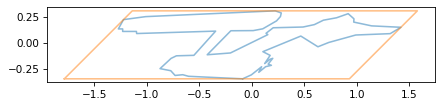

In [35]:
plot_contour(ship @ H)
plot_contour(bbox @ H, color='C1')

In [36]:
from utils import normalize

v = [1, 1]
v_hat = normalize(v)

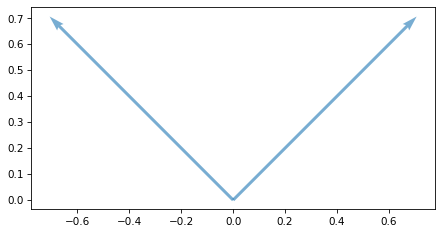

In [37]:
from utils import plot_vector

x, y = v_hat
perp = [-y, x]
plot_vector(v_hat)
plot_vector(perp)
decorate(aspect='equal')

In [38]:
def rotation_matrix(v_hat):
    x, y = v_hat
    return np.array([[x, y], [-y, x]])

In [39]:
R = rotation_matrix(v_hat)

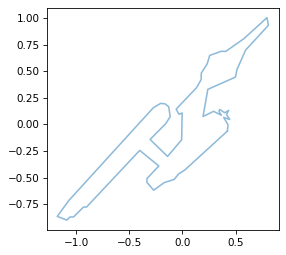

In [40]:
plot_contour(ship @ R)

## Composition

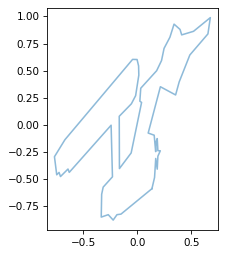

In [41]:
transformed = ship @ S @ H @ R
plot_contour(transformed)

In [42]:
T = S @ H @ R
T

array([[0.53033009, 0.53033009],
       [0.        , 2.12132034]])

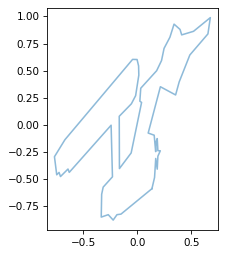

In [43]:
plot_contour(ship @ T)

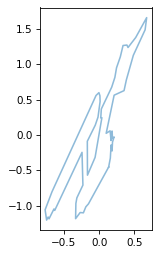

In [44]:
T2 = H @ R @ S
plot_contour(ship @ T2)

## Orbit

In [45]:
thetas = np.linspace(0, 2 * np.pi, 100)
circle = np.transpose([np.cos(thetas), np.sin(thetas)])
circle.shape

(100, 2)

In [46]:
a, b = 10, 7

In [47]:
c = np.sqrt(a**2 - b**2)
c

np.float64(7.14142842854285)

In [62]:
e = c / a
e

np.float64(0.7141428428542851)

In [63]:
c_vec = np.array([c, 0])

In [64]:
S = scale_matrix(a, b)
orbit = circle @ S + c_vec

In [106]:
r_vec = orbit[10]
r_vec

array([15.194131 ,  4.1503555])

In [107]:
from utils import norm

def vis_viva(r_vec, a, mu=1):
    r = norm(r_vec)
    v = np.sqrt(mu * (2 / r - 1 / a))
    return v
    
v = vis_viva(r_vec, a)
v

np.float64(0.16424932050106758)

In [108]:
def vector_perp(v):
    x, y = v
    return np.array([-y, x])

In [109]:
def ellipse_tangent(r_c, a, b):
    x, y = r_c
    n_vec = np.array([x / a**2, y / b**2])
    n_hat = normalize(n_vec)
    return n_hat, vector_perp(n_hat)

In [110]:
n_hat, v_hat = ellipse_tangent(r_vec-c_vec, a, b)

In [111]:
v_vec = v * v_hat
v_vec

array([-0.11903788,  0.11317165])

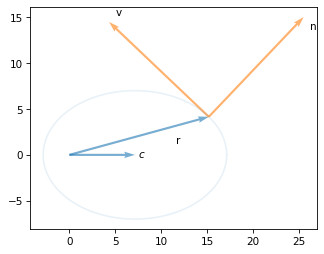

In [112]:
plot_vector(r_vec, label='r', label_pos=2)
plot_vector(c_vec, label='$c$')
plot_vector(n_hat, r_vec, scale=15, label='n', label_pos=1, color='C1')
plot_vector(v_hat, r_vec, scale=15, label='v', label_pos=1, color='C1')
plot_contour(orbit, alpha=0.1)

In [97]:
def compute_transform(r_vec, a, b, sol=1):
    v = vis_viva(r_vec, a)
    v_hat = ellipse_tangent(r_vec-c_vec, a, b) 
    
    R = rotation_matrix(v_hat)
    
    sx = np.sqrt(1 - v / sol)
    S = scale_matrix(sx, 1)
    
    F = scale_matrix(1, -1)
    return F @ S @ R

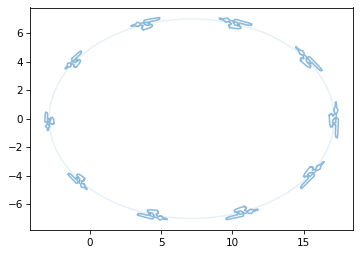

In [98]:
for r_vec in orbit[::10]:
    T = compute_transform(r_vec, a, b)
    transformed = ship @ T + r_vec
    plot_contour(transformed)
    
plot_contour(orbit, alpha=0.1)

[Think Linear Algebra](https://allendowney.github.io/ThinkLinearAlgebra/index.html)

Copyright 2025 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)